In [1]:
import librosa
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import neuro
import risp
import random

## Create a class for Chromogram

In [58]:
class Chromagram:
    
    def __init__(self, fn_wav, Fs=44100, N=2048, H=1024, gamma=None, version='CQT', norm='2'):
        self.fn_wav = fn_wav
        self.Fs = Fs
        self.N = N
        self.H = H
        self.gamma = gamma
        self.version = version
        self.norm = norm
        
        self.raw_audio, self.raw_Fs = self._load_audio()
        self.chromagram, self.Fs_X = self._compute_chromagram()
        self.num_frames, self.num_bins, self.time_steps = self.get_num_frames()
     
    #load audio    
    def _load_audio(self):
        return librosa.load(self.fn_wav, sr=self.Fs)
    
    #compute number of frames and number of bins, as well as time steps! Important for encoding parameters.
    def get_num_frames(self):
        
        num_frames = self.chromagram.shape[1]
        num_bins = self.chromagram.shape[0]
        time_steps = round(self.Fs_X**(-1) * 1000, 1)
        
        return num_frames, num_bins, time_steps
    
    #computes the chromagram in two different ways (STFT, CQT). Pick one (pick QCT for now).
    def _compute_chromagram(self):
        x, Fs = self.raw_audio, self.raw_Fs
        x_dur = x.shape[0] / Fs
        
        if self.version == 'STFT':
            X = librosa.stft(x, n_fft=self.N, hop_length=self.H, center=True, pad_mode='constant')
            if self.gamma is not None:
                X = np.log(1 + self.gamma * np.abs(X)**2)
            else:
                X = np.abs(X)**2
            X = librosa.feature.chroma_stft(S=X, sr=Fs, tuning=0, norm=None, hop_length=self.H, n_fft=self.N)
            
        if self.version == 'CQT':
            X = librosa.feature.chroma_cqt(y=x, sr=Fs, hop_length=self.H, norm=None)
            
        #Calls normalization function
        if self.norm is not None:
            X = Chromagram.normalize_feature_sequence(X, norm=self.norm)
          
        #Fs_X is the sampling rate of the chromagram  
        Fs_X = Fs / self.H
        
        return X, Fs_X
    
    #staticmethod just means its not dependent on the class itself
    #Noralizes the feature sequence
    @staticmethod
    def normalize_feature_sequence(X, norm='2', threshold=0.0001, v=None):
        """Normalizes the columns of a feature sequence
        Notebook: C3/C3S1_FeatureNormalization.ipynb

        Args:
            X (np.ndarray): Feature sequence
            norm (str): The norm to be applied. '1', '2', 'max' or 'z' (Default value = '2')
            threshold (float): An threshold below which the vector ``v`` used instead of normalization
                (Default value = 0.0001)
            v (float): Used instead of normalization below ``threshold``. If None, uses unit vector for given norm
                (Default value = None)

        Returns:
            X_norm (np.ndarray): Normalized feature sequence
        """
        assert norm in ['1', '2', 'max', 'z']

        K, N = X.shape
        X_norm = np.zeros((K, N))

        if norm == '1':
            if v is None:
                v = np.ones(K, dtype=np.float64) / K
            for n in range(N):
                s = np.sum(np.abs(X[:, n]))
                if s > threshold:
                    X_norm[:, n] = X[:, n] / s
                else:
                    X_norm[:, n] = v

        if norm == '2':
            if v is None:
                v = np.ones(K, dtype=np.float64) / np.sqrt(K)
            for n in range(N):
                s = np.sqrt(np.sum(X[:, n] ** 2))
                if s > threshold:
                    X_norm[:, n] = X[:, n] / s
                else:
                    X_norm[:, n] = v

        if norm == 'max':
            if v is None:
                v = np.ones(K, dtype=np.float64)
            for n in range(N):
                s = np.max(np.abs(X[:, n]))
                if s > threshold:
                    X_norm[:, n] = X[:, n] / s
                else:
                    X_norm[:, n] = v

        if norm == 'z':
            if v is None:
                v = np.zeros(K, dtype=np.float64)
            for n in range(N):
                mu = np.sum(X[:, n]) / K
                sigma = np.sqrt(np.sum((X[:, n] - mu) ** 2) / (K - 1))
                if sigma > threshold:
                    X_norm[:, n] = (X[:, n] - mu) / sigma
                else:
                    X_norm[:, n] = v

        return X_norm

### Plot the chromogram just to see how it looks :3
I stole this code from a textbook about music analysis :P

In [3]:
def plot_chromagram(*args, chroma_yticks=np.arange(12), **kwargs):
    """Call libfmp.b.plot_matrix and sets chroma labels.

    See :func:`libfmp.b.b_plot.plot_matrix` for parameters and return values.
    """
    if 'ylabel' not in kwargs:
        kwargs['ylabel'] = 'Chroma'
    fig, ax, im = plot_matrix(*args, **kwargs)

    chroma_names = 'C C# D D# E F F# G G# A A# B'.split()
    ax[0].set_yticks(np.array(chroma_yticks))
    ax[0].set_yticklabels([chroma_names[i] for i in chroma_yticks])

    return fig, ax, im

def plot_matrix(X, Fs=1, Fs_F=1, T_coef=None, F_coef=None, xlabel='Time (seconds)', ylabel='Frequency (Hz)',
                xlim=None, ylim=None, clim=None, title='', dpi=72,
                colorbar=True, colorbar_aspect=20.0, cbar_label='', ax=None, figsize=(6, 3), **kwargs):
    """2D raster visualization of a matrix, e.g. a spectrogram or a tempogram.

    Args:
        X: The matrix
        Fs: Sample rate for axis 1 (Default value = 1)
        Fs_F: Sample rate for axis 0 (Default value = 1)
        T_coef: Time coeffients. If None, will be computed, based on Fs. (Default value = None)
        F_coef: Frequency coeffients. If None, will be computed, based on Fs_F. (Default value = None)
        xlabel: Label for x-axis (Default value = 'Time (seconds)')
        ylabel: Label for y-axis (Default value = 'Frequency (Hz)')
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for y-axis (Default value = None)
        clim: Color limits (Default value = None)
        title: Title for plot (Default value = '')
        dpi: Dots per inch (Default value = 72)
        colorbar: Create a colorbar. (Default value = True)
        colorbar_aspect: Aspect used for colorbar, in case only a single axes is used. (Default value = 20.0)
        cbar_label: Label for colorbar (Default value = '')
        ax: Either (1.) a list of two axes (first used for matrix, second for colorbar), or (2.) a list with a single
            axes (used for matrix), or (3.) None (an axes will be created). (Default value = None)
        figsize: Width, height in inches (Default value = (6, 3))
        **kwargs: Keyword arguments for matplotlib.pyplot.imshow

    Returns:
        fig: The created matplotlib figure or None if ax was given.
        ax: The used axes.
        im: The image plot
    """
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
        ax = [ax]
    if T_coef is None:
        T_coef = np.arange(X.shape[1]) / Fs
    if F_coef is None:
        F_coef = np.arange(X.shape[0]) / Fs_F

    if 'extent' not in kwargs:
        x_ext1 = (T_coef[1] - T_coef[0]) / 2
        x_ext2 = (T_coef[-1] - T_coef[-2]) / 2
        y_ext1 = (F_coef[1] - F_coef[0]) / 2
        y_ext2 = (F_coef[-1] - F_coef[-2]) / 2
        kwargs['extent'] = [T_coef[0] - x_ext1, T_coef[-1] + x_ext2, F_coef[0] - y_ext1, F_coef[-1] + y_ext2]
    if 'cmap' not in kwargs:
        kwargs['cmap'] = 'gray_r'
    if 'aspect' not in kwargs:
        kwargs['aspect'] = 'auto'
    if 'origin' not in kwargs:
        kwargs['origin'] = 'lower'
    if 'interpolation' not in kwargs:
        kwargs['interpolation'] = 'nearest'

    im = ax[0].imshow(X, **kwargs)

    if len(ax) == 2 and colorbar:
        cbar = plt.colorbar(im, cax=ax[1])
        cbar.set_label(cbar_label)
    elif len(ax) == 2 and not colorbar:
        ax[1].set_axis_off()
    elif len(ax) == 1 and colorbar:
        plt.sca(ax[0])
        cbar = plt.colorbar(im, aspect=colorbar_aspect)
        cbar.set_label(cbar_label)

    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    ax[0].set_title(title)
    if xlim is not None:
        ax[0].set_xlim(xlim)
    if ylim is not None:
        ax[0].set_ylim(ylim)
    if clim is not None:
        im.set_clim(clim)

    if fig is not None:
        plt.tight_layout()

    return fig, ax, im

/home/dofo/framework/pyframework/lib/python3.11/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=691
  warnings.warn(


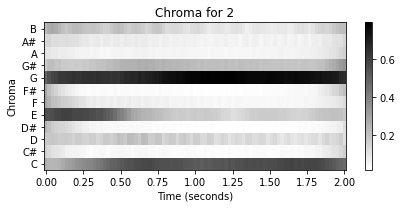

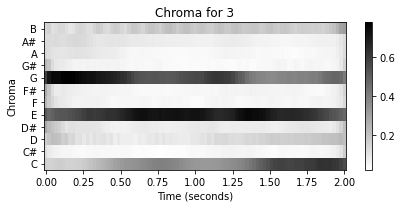

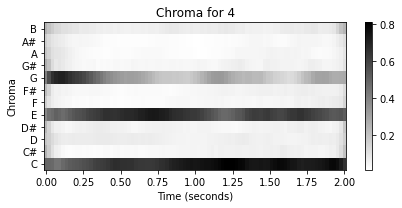

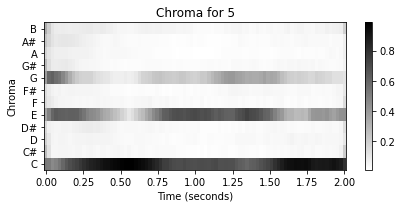

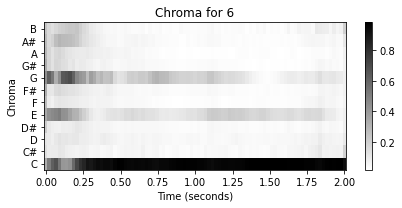

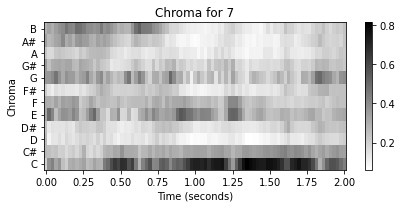

In [4]:
song_samples = [
    "/home/dofo/Desktop/music/chords/major_triad/major_triad36.wav",
    "/home/dofo/Desktop/music/chords/major_triad/major_triad48.wav",
    "/home/dofo/Desktop/music/chords/major_triad/major_triad60.wav",
    "/home/dofo/Desktop/music/chords/major_triad/major_triad72.wav",
    "/home/dofo/Desktop/music/chords/major_triad/major_triad84.wav",
    "/home/dofo/Desktop/music/chords/major_triad/major_triad96.wav"
]

song_samples_2 = [
    "/home/dofo/Desktop/music/chords/major_triad/D274_major_triad36.wav",
    "/home/dofo/Desktop/music/chords/major_triad/D274_major_triad48.wav",
    "/home/dofo/Desktop/music/chords/major_triad/D274_major_triad60.wav",
    "/home/dofo/Desktop/music/chords/major_triad/D274_major_triad72.wav",
    "/home/dofo/Desktop/music/chords/major_triad/D274_major_triad84.wav",
    "/home/dofo/Desktop/music/chords/major_triad/D274_major_triad96.wav"
]

c_val = 2
for song in song_samples:
    chroma = Chromagram(song)
    
    plot_chromagram(chroma.chromagram, Fs=chroma.Fs_X, title=f"Chroma for {c_val}")
    c_val += 1

In [76]:
# TODO: This is specific to the two second clips of the chord dataset. I'll generalize it later.
class Encoder:
    
    def __init__(self, fn_wav):
        
        chromagram = Chromagram(fn_wav)                 # chromagram object for us to call on
        
        self.fn_wav = fn_wav                            # filename of wav file
        self.num_frames = chromagram.num_frames               
        self.num_bins = chromagram.num_bins   
        self.time_steps = chromagram.time_steps     
        
        self.chroma_as_list = self._get_chroma()         # chromagram as list
        
        self.encoder_params = {
            "dmin": self.num_bins * [0],
            "dmax": self.num_bins * [1],
            "encoders": [{ "rate": { "subinterval_size": self.time_steps } }],
            "interval": self.time_steps * self.num_frames,
            }
        
        self.spikes = self._encode()                     # encoded chromagram
        
     
    def _get_chroma(self):
        chroma = Chromagram(self.fn_wav).chromagram
        return chroma.tolist()

    def _encode(self):
        encoder = neuro.EncoderArray(self.encoder_params)
        spikes = encoder.get_timeseries_spikes(self.chroma_as_list)
        return spikes    

In [77]:
encoder_test = (Encoder("/home/dofo/Desktop/music/chords/major_triad/major_triad84.wav").spikes)

In [79]:
len(encoder_test)

4129

In [40]:
ex_c = (Chromagram("/home/dofo/Desktop/music/chords/major_triad/major_triad84.wav").chromagram)

ex_c.tolist()

[[0.32849249243736267,
  0.5122330188751221,
  0.623399019241333,
  0.6703123450279236,
  0.5350683331489563,
  0.4114305078983307,
  0.40281301736831665,
  0.43056485056877136,
  0.5857223272323608,
  0.7161015272140503,
  0.7964301705360413,
  0.8416614532470703,
  0.9054284691810608,
  0.8858017921447754,
  0.9137095212936401,
  0.9412081241607666,
  0.9315410852432251,
  0.944583535194397,
  0.9424010515213013,
  0.9379729628562927,
  0.9683933854103088,
  0.9765027761459351,
  0.9727259278297424,
  0.9644836187362671,
  0.9568147659301758,
  0.952268123626709,
  0.957953691482544,
  0.955901026725769,
  0.9519063234329224,
  0.9602450132369995,
  0.9513777494430542,
  0.9391594529151917,
  0.9356729388237,
  0.9482263326644897,
  0.9508025646209717,
  0.9535169005393982,
  0.9644628167152405,
  0.9679375886917114,
  0.9706814289093018,
  0.9724355340003967,
  0.9733330011367798,
  0.9688063859939575,
  0.9687546491622925,
  0.9713510274887085,
  0.9658475518226624,
  0.96634101867

In [ ]:
ex_c = (Chromagram("/home/dofo/Desktop/music/chords/major_triad/major_triad84.wav").chromagram)


In [54]:
ex_raw = (Chromagram("/home/dofo/Desktop/music/chords/major_triad/major_triad84.wav").raw_audio)
len(ex_raw)

/home/dofo/framework/pyframework/lib/python3.11/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=691
  warnings.warn(


88384

In [34]:
ex_fs = (Chromagram("/home/dofo/Desktop/music/chords/major_triad/major_triad84.wav").Fs_X)

ex_fs

/home/dofo/framework/pyframework/lib/python3.11/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=691
  warnings.warn(


43.06640625

In [59]:
num_frames = (Chromagram("/home/dofo/Desktop/music/chords/major_triad/major_triad84.wav").num_frames)
num_bins = (Chromagram("/home/dofo/Desktop/music/chords/major_triad/major_triad84.wav").num_bins)
time_steps = (Chromagram("/home/dofo/Desktop/music/chords/major_triad/major_triad84.wav").time_steps)

print(num_frames)
print(num_bins)
print(time_steps)

/home/dofo/framework/pyframework/lib/python3.11/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=691
  warnings.warn(


87
12
23.2


In [61]:
encoder_params = {
  "dmin": num_bins * [0],
  "dmax": num_bins * [1],
  "encoders": [{ "rate": { "subinterval_size": time_steps } }],
  "interval": time_steps * num_frames,
}

encoder = neuro.EncoderArray(encoder_params)

spikes = encoder.get_timeseries_spikes(ex_c)

len(spikes)

4129

In [7]:

risp_config = {
  "leak_mode": "all",
  "min_weight": -1,
  "max_weight": 1,
  "min_threshold": -1,
  "max_threshold": 1,
  "max_delay": 5,
  "discrete": False
}

proc = risp.Processor(risp_config)

net = neuro.Network()
net.set_properties(proc.get_network_properties())


In [8]:
n_inputs = 12
n_neurons = n_inputs
seed = 42

moa = neuro.MOA()
moa.seed(seed)
random.seed(seed)

In [9]:
def create_neuron(neuron_id, net, moa):
    neuron = net.add_node(neuron_id)
    net.randomize_node_properties(moa, neuron)
    return neuron

In [10]:
for i in range(n_inputs):
    neuron = create_neuron(i, net, moa)
    neuron.set("Threshold",0.75)
    net.add_input(neuron.id)



In [11]:
proc.load_network(net)

for i in range(net.num_nodes()):
    proc.track_neuron_events(i)

proc.apply_spikes(spikes)
proc.run(100)
v = proc.neuron_vectors()

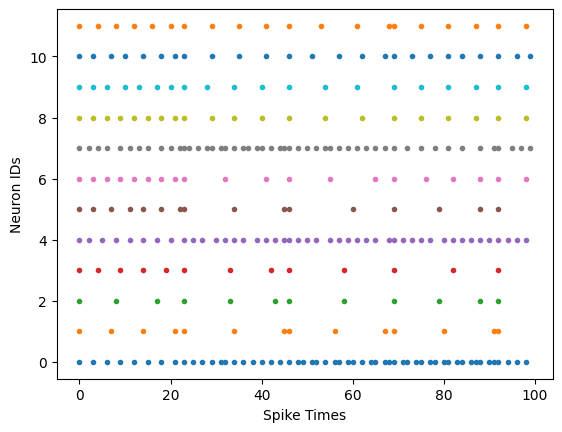

In [12]:

import matplotlib.pyplot as plt

plt.xlabel("Spike Times")
plt.ylabel("Neuron IDs")

for i in range(len(v)):
    plt.plot(v[i], [i]*len(v[i]), '.')

(<Figure size 432x216 with 2 Axes>,
 [<Axes: xlabel='Time (seconds)', ylabel='Chroma'>],
 <matplotlib.image.AxesImage at 0x7f14c9e60710>)

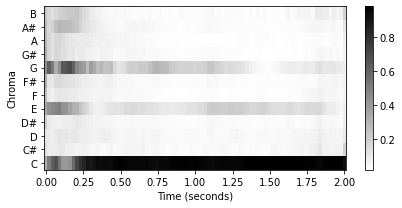

In [13]:
plot_chromagram(Chromagram("/home/dofo/Desktop/music/chords/major_triad/major_triad84.wav").chromagram, Fs=Chromagram("/home/dofo/Desktop/music/chords/major_triad/major_triad84.wav").Fs_X)

In [14]:

proc.clear_activity()